### Cell1 - making groups ###

In [9]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict

# =========================
# CONFIGURATION
# =========================
# Construct the path to the data file:
DATA_FILE = os.path.join(os.path.pardir, 'data_prep', 'family_data.xlsx')
PERSON_ID_COLUMN = 'PersonID'
PARTNER_ID_COLUMN = 'PartnerID'
PARENT_COLUMNS = ['FatherID', 'MotherID']
NAME_RU_COLUMN = 'Name-ru'
# =========================
# HELPER FUNCTIONS 
# =========================

def load_data(file_path):
    """
    Load data and ensure IDs are integers for processing. 
    Exits immediately if the file is not found.
    """
    try:
        # Read the Excel file
        df = pd.read_excel(file_path)
    except FileNotFoundError:
        # Print error and exit the script
        print(f"FATAL ERROR: Data file '{file_path}' not found.")
        print("Please ensure the file is in the parent directory's 'data_prep' folder.")
        exit(1) # Exit with a non-zero code to indicate an error
    except Exception as e:
        # Handle other potential loading errors (e.g., corrupted file)
        print(f"FATAL ERROR: An unexpected error occurred while reading the Excel file: {e}")
        exit(1)

    # Ensure IDs are integers
    df[PERSON_ID_COLUMN] = df[PERSON_ID_COLUMN].astype(int)
    
    # Clean up partner/parent IDs (assuming they might be floats)
    for col in [PARTNER_ID_COLUMN] + PARENT_COLUMNS:
        if col in df.columns:
            # Simple conversion for single IDs
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
            df.loc[df[col] == 0, col] = np.nan # set 0 back to NaN
    
    # Ensure Name-ru exists, or fallback to 'Name'
    if NAME_RU_COLUMN not in df.columns:
        if 'Name' in df.columns:
            df[NAME_RU_COLUMN] = df['Name']
        else:
            df[NAME_RU_COLUMN] = df[PERSON_ID_COLUMN].astype(str) # Final fallback
    
    return df

def get_partner_id(df_ref, person_id):
    """Safely retrieves the integer partner ID if it exists and is in the dataframe."""
    row_match = df_ref[df_ref[PERSON_ID_COLUMN] == person_id]
    if row_match.empty:
        return None
        
    partner_val = row_match[PARTNER_ID_COLUMN].iloc[0]
    
    if pd.notna(partner_val):
        partner_id = int(partner_val)
        # Check if the partner ID actually exists in the PersonID column
        if partner_id in df_ref[PERSON_ID_COLUMN].values:
            return partner_id
    return None

def get_siblings_by_parent_ids(df_ref, person_id, generation):
    """
    Finds all people in the specified generation who share the same non-NaN parents
    as the given person_id. 
    """
    row_match = df_ref[df_ref[PERSON_ID_COLUMN] == person_id]
    if row_match.empty:
        return []
        
    row = row_match.iloc[0]
    father = row.get(PARENT_COLUMNS[0])
    mother = row.get(PARENT_COLUMNS[1])
    
    siblings_df = df_ref[df_ref['Generation'] == generation]
    
    # If no parents are known, the person is treated as their own group start
    if pd.isna(father) and pd.isna(mother):
        return [person_id] 
    
    # Filter based on known parents
    condition = (siblings_df['Generation'] == generation)
    
    # Build conditions robustly
    if pd.notna(father):
        condition &= (siblings_df[PARENT_COLUMNS[0]] == father)
    else:
        condition &= siblings_df[PARENT_COLUMNS[0]].isna()

    if pd.notna(mother):
        condition &= (siblings_df[PARENT_COLUMNS[1]] == mother)
    else:
        condition &= siblings_df[PARENT_COLUMNS[1]].isna()

    return siblings_df[condition][PERSON_ID_COLUMN].tolist()

def create_clan_groups(df, gen_num):
    """
    Groups people in a generation based on the iterative sibling/spouse connection rule.
    Returns a list of sets (unsorted groups).
    """
    gen_df = df[df['Generation'] == gen_num]
    gen_ids = set(gen_df[PERSON_ID_COLUMN].tolist())
    unprocessed_ids = gen_ids.copy()
    all_groups_sets = []
    
    while unprocessed_ids:
        start_id = min(unprocessed_ids) # Start with the lowest ID for determinism
        
        # --- 1. Find the initial sibling group ---
        initial_cluster = get_siblings_by_parent_ids(df, start_id, gen_num)
        
        current_group = set()
        queue = set()
        
        for p_id in initial_cluster:
            if p_id in unprocessed_ids:
                queue.add(p_id)
                current_group.add(p_id)
        
        if not queue:
            unprocessed_ids.discard(start_id)
            continue
            
        # --- 2-5. Iterative Expansion (BFS-like on partner/sibling connections) ---
        
        while queue:
            partners_added = set()
            
            # Phase 1: Expand Partners (Steps 2 & 4)
            for p_id in queue:
                partner = get_partner_id(df, p_id)
                if partner and partner in gen_ids and partner not in current_group:
                    current_group.add(partner)
                    partners_added.add(partner)

            # Phase 2: Expand Siblings of the new Partners (Steps 3 & 5)
            siblings_of_partners_added = set()
            
            for p_id in partners_added:
                partner_siblings = get_siblings_by_parent_ids(df, p_id, gen_num)
                for s_id in partner_siblings:
                    if s_id in gen_ids and s_id not in current_group:
                        current_group.add(s_id)
                        siblings_of_partners_added.add(s_id)
                        
            # The next queue contains the newly added siblings, whose partners will be checked next
            queue = siblings_of_partners_added.copy()

        # Group is stabilized, save it and update unprocessed list
        all_groups_sets.append(current_group)
        unprocessed_ids -= current_group

    return all_groups_sets

def group_people_by_siblings(df_ref, people_ids):
    """Identifies and groups people by their unique set of parents within the provided set of people."""
    sibling_sets = defaultdict(list)
    
    for person_id in people_ids:
        row_match = df_ref[df_ref[PERSON_ID_COLUMN] == person_id]
        if row_match.empty:
            continue
            
        row = row_match.iloc[0]
        father = row.get(PARENT_COLUMNS[0])
        mother = row.get(PARENT_COLUMNS[1])
        
        # Create a stable key for the parent set
        parent_key = tuple(sorted([
            int(father) if pd.notna(father) else 0,
            int(mother) if pd.notna(mother) else 0
        ]))
        
        # If no parents, use a unique key based on the person's ID (they are a family unit of 1)
        if parent_key == (0, 0):
             parent_key = (person_id, person_id) 

        sibling_sets[parent_key].append(person_id)
        
    return sibling_sets

def get_partner_in_group(df_ref, person_id, group_ids):
    """Safely retrieves the partner ID if it exists and is within the given group."""
    partner_id = get_partner_id(df_ref, person_id)
    return partner_id if partner_id and partner_id in group_ids else None

def sort_group_internally(df_ref, group_ids, gen_num):
    """
    Applied the user's complex conditional sorting logic within a single clan group.
    Returns the final ordered list of person IDs.
    """
    
    # 1. Map all people in the group to their sibling set key (parent_key)
    sibling_sets_map = group_people_by_siblings(df_ref, group_ids)
    
    final_sorted_group = []
    processed_ids = set()
    
    # Helper to add a person to the sorted list and processed set
    def _place_person(p_id):
        if p_id not in processed_ids:
            final_sorted_group.append(p_id)
            processed_ids.add(p_id)
    
    # Find the starting ID (lowest ID) and its parent key (Primary Family Unit Key)
    start_id = min(group_ids)
    
    primary_key = None
    for key, ids in sibling_sets_map.items():
        if start_id in ids:
            primary_key = key
            break
            
    if not primary_key:
        return sorted(list(group_ids)) # Fallback
    
    # Initialize queue for expansion (Steps 7-9)
    family_unit_keys_to_process = []
    queued_family_unit_keys = set()
    
    # --- PHASE 1: Process the Primary Family Unit (Conditional Start) ---
    
    current_key = primary_key
    primary_family_ids = sorted([p for p in sibling_sets_map.get(current_key, []) if p in group_ids])
    
    singles = []
    partnered_siblings = [] 
    
    # Separate the family unit members into Singles and Partnered Siblings
    for p_id in primary_family_ids:
        if p_id in processed_ids: continue
        
        partner_id = get_partner_in_group(df_ref, p_id, group_ids)
        
        if partner_id:
            # Use the lower ID to ensure we only process the couple once
            couple_key = tuple(sorted((p_id, partner_id)))
            if p_id == couple_key[0]: 
                partnered_siblings.append(p_id) 
        else:
            singles.append(p_id)

    # Sort partnered siblings by ID to identify the anchor
    partnered_siblings.sort() 
    anchor_sibling_id = partnered_siblings[0] if partnered_siblings else None
    
    partners_for_expansion = [] 
    
    # --- Case A: If there are singles (Logic 1-6) ---
    if singles:
        # Steps 1-3: Place all unpartnered siblings first
        for s_id in singles:
            _place_person(s_id)

        # Iterate through partnered siblings
        for p_id in partnered_siblings:
            partner_id = get_partner_in_group(df_ref, p_id, group_ids)
            
            if p_id not in processed_ids and partner_id and partner_id not in processed_ids:
                # Steps 4-6: Place Sibling, then Partner
                _place_person(p_id)
                _place_person(partner_id)
                
                # Queue partner's family key
                partner_key = None
                for key, ids in sibling_sets_map.items():
                    if partner_id in ids:
                        partner_key = key
                        break
                if partner_key and partner_key != current_key:
                    partners_for_expansion.append(partner_key)

    # --- Case B: If there are NO singles (Logic 1-2 from second list) ---
    elif partnered_siblings:
        for p_id in partnered_siblings:
            partner_id = get_partner_in_group(df_ref, p_id, group_ids)
            
            if p_id not in processed_ids and partner_id and partner_id not in processed_ids:
                is_anchor = (p_id == anchor_sibling_id)
                
                partner_key = None
                for key, ids in sibling_sets_map.items():
                    if partner_id in ids:
                        partner_key = key
                        break
                
                # Step 1: Anchor Sibling Rule: Place Partner, then Sibling
                if is_anchor:
                    _place_person(partner_id) 
                    _place_person(p_id) 
                    
                # Steps 5-6/Step 2: Regular Rule: Place Sibling, then Partner
                else:
                    _place_person(p_id) 
                    _place_person(partner_id)
                
                # Queue partner's family key for expansion (Steps 7-9)
                if partner_key and partner_key != current_key:
                    partners_for_expansion.append(partner_key)


    # --- PHASE 2: Populate Initial Queue for Expansion (Steps 7-9) ---
    
    if partners_for_expansion:
        # Ensure anchor's partner's family is processed first (Steps 7-8)
        anchor_partner_key = partners_for_expansion[0]
        if anchor_partner_key not in queued_family_unit_keys:
            family_unit_keys_to_process.append(anchor_partner_key)
            queued_family_unit_keys.add(anchor_partner_key)
            
        # Process remaining partners' families (Step 9)
        for other_partner_key in partners_for_expansion[1:]:
            if other_partner_key not in queued_family_unit_keys:
                family_unit_keys_to_process.append(other_partner_key)
                queued_family_unit_keys.add(other_partner_key)

    # --- PHASE 3: Process Secondary Family Units (Looping through the queue) ---
    
    current_key_index = 0
    while current_key_index < len(family_unit_keys_to_process) and len(processed_ids) < len(group_ids):
        current_key = family_unit_keys_to_process[current_key_index]
        current_key_index += 1 # Advance pointer immediately

        current_family_ids = sorted([p for p in sibling_sets_map.get(current_key, []) if p in group_ids])
        
        # 1. Separate members again
        secondary_singles = []
        secondary_partnered_siblings = [] 

        for p_id in current_family_ids:
            if p_id in processed_ids: continue
            
            partner_id = get_partner_in_group(df_ref, p_id, group_ids)
            
            if partner_id:
                couple_key = tuple(sorted((p_id, partner_id)))
                if p_id == couple_key[0]: 
                    secondary_partnered_siblings.append(p_id) 
            else:
                secondary_singles.append(p_id)

        # 2. Place Singles first
        for s_id in secondary_singles:
            _place_person(s_id)

        # 3. Place Couples (Sibling, then Partner) and queue new partners
        for p_id in secondary_partnered_siblings:
            partner_id = get_partner_in_group(df_ref, p_id, group_ids)
            
            if p_id not in processed_ids and partner_id and partner_id not in processed_ids:
                
                _place_person(p_id)
                _place_person(partner_id)

                # Queue partner's family key (Steps 7-9 again for subsequent levels of expansion)
                partner_key = None
                for key, ids in sibling_sets_map.items():
                    if partner_id in ids:
                        partner_key = key
                        break
                        
                if partner_key and partner_key != current_key and partner_key not in queued_family_unit_keys:
                    family_unit_keys_to_process.append(partner_key)
                    queued_family_unit_keys.add(partner_key)

    # Add any truly remaining, unplaced people (e.g., if they were isolated singles)
    remaining = [p for p in group_ids if p not in processed_ids]
    final_sorted_group.extend(sorted(remaining)) 
    
    return final_sorted_group

# =========================
# MAIN EXECUTION (Modified to save ordered lists)
# =========================

# Load and prepare data - Will now exit if file is not found
df = load_data(DATA_FILE)

# Initialize storage for all sorted groups: {generation: [list_of_group_1_IDs, list_of_group_2_IDs, ...]}
all_sorted_groups_by_gen = {} 

# Identify generations
generations = sorted(df['Generation'].unique())
name_map = df.set_index(PERSON_ID_COLUMN)[NAME_RU_COLUMN].to_dict()

print("--- Clan Grouping and Complex Internal Sorting Results ---")

for gen_num in generations:
    if gen_num == 0: continue
        
    # 1. Create the large clan groups (unsorted sets of IDs)
    groups_sets = create_clan_groups(df, gen_num)
    
    print(f"\n======================================")
    print(f"=== Generation {gen_num} ({len(groups_sets)} Groups) ===")
    print(f"======================================")
    
    # List to hold the sorted lists for the current generation
    sorted_groups_for_gen = []
    
    for i, group_ids_set in enumerate(groups_sets):
        # 2. Sort the group internally (returns the ordered list)
        sorted_group = sort_group_internally(df, group_ids_set, gen_num)

        # 3. Store the sorted group list
        sorted_groups_for_gen.append(sorted_group)

        # 4. Print the sorted results
        group_details = [f"ID {p}: {name_map.get(p, 'N/A')}" for p in sorted_group]
        print(f"Group {i+1} ({len(sorted_group)} people):")
        for detail in group_details:
             print(f"  - {detail}")
        print("-" * 20)

    # Save the complete list of ordered groups for this generation
    all_sorted_groups_by_gen[gen_num] = sorted_groups_for_gen

print("\n--- Data Ready for Cell 2 ---")
print("The variable 'all_sorted_groups_by_gen' now contains the internally sorted groups as lists of lists, accessible by generation number.")

--- Clan Grouping and Complex Internal Sorting Results ---

=== Generation 1 (2 Groups) ===
Group 1 (2 people):
  - ID 58: Фёкла
  - ID 51: Каземир
--------------------
Group 2 (2 people):
  - ID 60: Уститья
  - ID 59: Тарас
--------------------

=== Generation 2 (1 Groups) ===
Group 1 (3 people):
  - ID 32: Василий
  - ID 31: Софья
  - ID 52: Фёдор
--------------------

=== Generation 3 (2 Groups) ===
Group 1 (2 people):
  - ID 28: Вера
  - ID 27: Аппалинарий
--------------------
Group 2 (8 people):
  - ID 30: Александр
  - ID 29: Лилина
  - ID 33: Фёдор
  - ID 36: Евгения
  - ID 34: Ольга
  - ID 38: Иван
  - ID 35: Николай
  - ID 44: Нина
--------------------

=== Generation 4 (5 Groups) ===
Group 1 (8 people):
  - ID 2: Марина
  - ID 1: Михаил
  - ID 21: Леонид
  - ID 22: Елена
  - ID 14: Ольга
  - ID 15: Дмитрий
  - ID 18: Сергей
  - ID 19: Виктория
--------------------
Group 2 (2 people):
  - ID 11: Милана
  - ID 10: Николай
--------------------
Group 3 (2 people):
  - ID 53: Ната

### Cell 2 - creating df_combined for groups ###

In [10]:
# =============================================================
# COMBINING GROUPS: KEEPING ALL CONNECTIONS (Youngest → Oldest)
# =============================================================

import numpy as np
import pandas as pd

MAX_ORIGINAL_ID = df[PERSON_ID_COLUMN].max()
NEW_ID_START = MAX_ORIGINAL_ID + 1000

new_data_records = []
current_new_id = NEW_ID_START

original_to_new_id_map = {}
original_groups_count = 0
combined_groups_for_viz = {}

# ---------- Stage 1: Combine groups (reverse generation order) ----------
for gen_num, list_of_groups in sorted(all_sorted_groups_by_gen.items(), key=lambda item: item[0], reverse=True):
    original_groups_count += len(list_of_groups)
    combined_groups_for_gen = []

    for group_index, group_ids in enumerate(list_of_groups):
        combined_id = current_new_id
        current_new_id += 1
        combined_groups_for_gen.append([combined_id])

        for pid in group_ids:
            original_to_new_id_map[int(pid)] = combined_id

        anchor_person_id = group_ids[0]
        anchor_name = name_map.get(anchor_person_id, f"ID {anchor_person_id}")
        combined_name = f"Группа {gen_num}-{group_index+1} ({anchor_name})"

        # Collect ALL external partners + all parents (original ID space)
        external_partners, fathers, mothers = set(), set(), set()

        for pid in group_ids:
            row = df.loc[df[PERSON_ID_COLUMN] == pid]
            if row.empty:
                continue
            row = row.iloc[0]

            # Partner
            partner_id = row.get(PARTNER_ID_COLUMN)
            if pd.notna(partner_id):
                partner_id = int(partner_id)
                if partner_id not in group_ids:
                    external_partners.add(partner_id)

            # Parents
            father = row.get(PARENT_COLUMNS[0])
            mother = row.get(PARENT_COLUMNS[1])
            if pd.notna(father) and int(father) != 0:
                fathers.add(int(father))
            if pd.notna(mother) and int(mother) != 0:
                mothers.add(int(mother))

        new_record = {
            PERSON_ID_COLUMN: combined_id,
            NAME_RU_COLUMN: combined_name,
            "OriginalGroupIDs": list(group_ids),
            PARTNER_ID_COLUMN: sorted(list(external_partners)) if external_partners else np.nan,
            PARENT_COLUMNS[0]: sorted(list(fathers)) if fathers else np.nan,
            PARENT_COLUMNS[1]: sorted(list(mothers)) if mothers else np.nan,
            "Generation": gen_num,
        }
        new_data_records.append(new_record)

    combined_groups_for_viz[gen_num] = combined_groups_for_gen

df_combined_temp = pd.DataFrame(new_data_records)

# ---------- Stage 2: Remap IDs (handle lists properly) ----------
def remap_any(val):
    # Handle None / NaN directly
    if val is None:
        return np.nan

    # Handle list-like values (multiple IDs)
    if isinstance(val, (list, set, tuple, np.ndarray)):
        mapped = []
        for orig in val:
            if orig is None or (isinstance(orig, float) and pd.isna(orig)):
                continue
            try:
                orig_int = int(orig)
            except Exception:
                continue
            new_id = original_to_new_id_map.get(orig_int)
            if new_id is not None:
                mapped.append(int(new_id))
        return sorted(set(mapped)) if mapped else np.nan

    # Handle single scalar values
    try:
        if pd.isna(val):
            return np.nan
    except Exception:
        pass

    try:
        orig_int = int(val)
    except Exception:
        return np.nan

    return original_to_new_id_map.get(orig_int, np.nan)


for col in [PARTNER_ID_COLUMN] + PARENT_COLUMNS:
    df_combined_temp[col] = df_combined_temp[col].apply(remap_any)

# Remove self-links (self-parent/partner)
def remove_self_refs(row):
    cid = int(row[PERSON_ID_COLUMN])
    for col in [PARTNER_ID_COLUMN] + PARENT_COLUMNS:
        v = row[col]
        if isinstance(v, list):
            v = [x for x in v if x != cid]
            row[col] = v if v else np.nan
        elif pd.notna(v) and int(v) == cid:
            row[col] = np.nan
    return row

df_combined_temp = df_combined_temp.apply(remove_self_refs, axis=1)

# ---------- Stage 3: Final DataFrame ----------
df_combined = df_combined_temp[
    [
        PERSON_ID_COLUMN,
        NAME_RU_COLUMN,
        "Generation",
        PARTNER_ID_COLUMN,
        PARENT_COLUMNS[0],
        PARENT_COLUMNS[1],
        "OriginalGroupIDs",
    ]
].copy()

df_combined[PERSON_ID_COLUMN] = df_combined[PERSON_ID_COLUMN].astype(int)

# ---------- Stage 4: Build child (outgoing) connections ----------
child_connections = {gid: set() for gid in df_combined[PERSON_ID_COLUMN].unique()}

for _, row in df_combined.iterrows():
    child_id = int(row[PERSON_ID_COLUMN])
    for pcol in PARENT_COLUMNS:
        parents = row[pcol]
        if isinstance(parents, list):
            for pid in parents:
                if pd.notna(pid) and pid in child_connections:
                    child_connections[pid].add(child_id)
        elif pd.notna(parents) and parents in child_connections:
            child_connections[int(parents)].add(child_id)

child_connections = {k: sorted(list(v)) for k, v in child_connections.items() if v}

print("\n--- Combined Dataset df_combined Created ---")
print(f"Total Combined Entities: {len(df_combined)}")

# ---------- Stage 5: PRINT RESULTS (same style as your original) ----------
print("\n" + "=" * 40)
print("--- Detailed Group Information and Connections ---")

def get_connection_name(conn_id, is_child=False):
    if pd.isna(conn_id):
        return "N/A"
    conn_id = int(conn_id)
    conn_row = df_combined[df_combined[PERSON_ID_COLUMN] == conn_id]
    if not conn_row.empty:
        label = "Child Group" if is_child else "Group"
        return f"{label} ID {conn_id} ({conn_row.iloc[0][NAME_RU_COLUMN]})"
    return f"ID {conn_id} (Unresolved/Missing Group)"

for _, row in df_combined.iterrows():
    group_id = int(row[PERSON_ID_COLUMN])
    group_ids = row["OriginalGroupIDs"]
    people_names = [name_map.get(pid, f"Name not found for ID {pid}") for pid in group_ids]

    # Incoming / lateral
    incoming_connections_list = []
    for i, pcol in enumerate(PARENT_COLUMNS, start=1):
        parents = row[pcol]
        if isinstance(parents, list):
            for pid in parents:
                incoming_connections_list.append(f"Parent {i}: {get_connection_name(pid)}")
        elif pd.notna(parents):
            incoming_connections_list.append(f"Parent {i}: {get_connection_name(parents)}")

    partners = row[PARTNER_ID_COLUMN]
    if isinstance(partners, list):
        for pid in partners:
            incoming_connections_list.append(f"Partner: {get_connection_name(pid)}")
    elif pd.notna(partners):
        incoming_connections_list.append(f"Partner: {get_connection_name(partners)}")

    # Outgoing children
    outgoing_connections_list = []
    for cid in child_connections.get(group_id, []):
        outgoing_connections_list.append(get_connection_name(cid, is_child=True))

    print(f"\nGroup Name: {row[NAME_RU_COLUMN]} (New ID: {group_id})")
    print(f"  Generation: {int(row['Generation'])}")
    print(f"  Total People: {len(group_ids)}")
    print(f"  People IDs: {group_ids}")
    print(f"  People Names: {people_names}")
    print(f"  -------------------")
    print("  Incoming Connections:")
    if incoming_connections_list:
        print("    " + "\n    ".join(incoming_connections_list))
    else:
        print("    N/A")
    print(f"  Outgoing Children Groups ({len(outgoing_connections_list)}):")
    if outgoing_connections_list:
        print("    " + "\n    ".join(outgoing_connections_list))
    else:
        print("    N/A")

print("\n" + "=" * 40)
final_groups_count = len(df_combined)
print("--- Group Count Summary ---")
print(f"Original Total Number of Groups: {original_groups_count}")
print(f"Final Total Number of Entities in df_combined: {final_groups_count}")
print("=" * 40)



--- Combined Dataset df_combined Created ---
Total Combined Entities: 22

--- Detailed Group Information and Connections ---

Group Name: Группа 6-1 (Святик) (New ID: 1060)
  Generation: 6
  Total People: 1
  People IDs: [7]
  People Names: ['Святик']
  -------------------
  Incoming Connections:
    Parent 1: Group ID 1064 (Группа 5-1 (Сергей))
    Parent 2: Group ID 1064 (Группа 5-1 (Сергей))
  Outgoing Children Groups (0):
    N/A

Group Name: Группа 6-2 (Глеб) (New ID: 1061)
  Generation: 6
  Total People: 2
  People IDs: [12, 13]
  People Names: ['Глеб', 'Мария']
  -------------------
  Incoming Connections:
    Parent 1: Group ID 1064 (Группа 5-1 (Сергей))
    Parent 2: Group ID 1064 (Группа 5-1 (Сергей))
  Outgoing Children Groups (0):
    N/A

Group Name: Группа 6-3 (Юняша) (New ID: 1062)
  Generation: 6
  Total People: 2
  People IDs: [25, 26]
  People Names: ['Юняша', 'Элина']
  -------------------
  Incoming Connections:
    Parent 1: Group ID 1065 (Группа 5-2 (Игорь))
    

### Cell 3 - loading and the visualization of order structure ###

--- Attempting to load regrouped files: ..\manual_order_collapsed_regrouped.js and ..\manual_order_regrouped.js ---
--- Loading and Displaying Group Order (..\manual_order_collapsed_regrouped.js) ---

Generation 1 (Groups, Total: 2):
   1080 -> 1081

Generation 2 (Groups, Total: 1):
   1079

Generation 3 (Groups, Total: 2):
   1077 -> 1078

Generation 4 (Groups, Total: 5):
   1073 -> 1072 -> 1075 -> 1074 -> 1076

Generation 5 (Groups, Total: 8):
   1064 -> 1065 -> 1066 -> 1067 -> 1068 -> 1071 -> 1069 -> 1070

Generation 6 (Groups, Total: 4):
   1060 -> 1061 -> 1062 -> 1063


--- Loading and Displaying Full Person Order (..\manual_order_regrouped.js) ---

Generation 1 (Individuals, Total: 4):
   59 -> 60 -> 51 -> 58

Generation 2 (Individuals, Total: 3):
   31 -> 32 -> 52

Generation 3 (Individuals, Total: 10):
   28 -> 27 -> 30 -> 29 -> 33 -> 36 -> 34 -> 38 -> 35 -> 44

Generation 4 (Individuals, Total: 18):
   11 -> 10 -> 2 -> 1 -> 21 -> 22 -> 14 -> 15 -> 18 -> 19 -> 56 -> 39 -> 40 ->

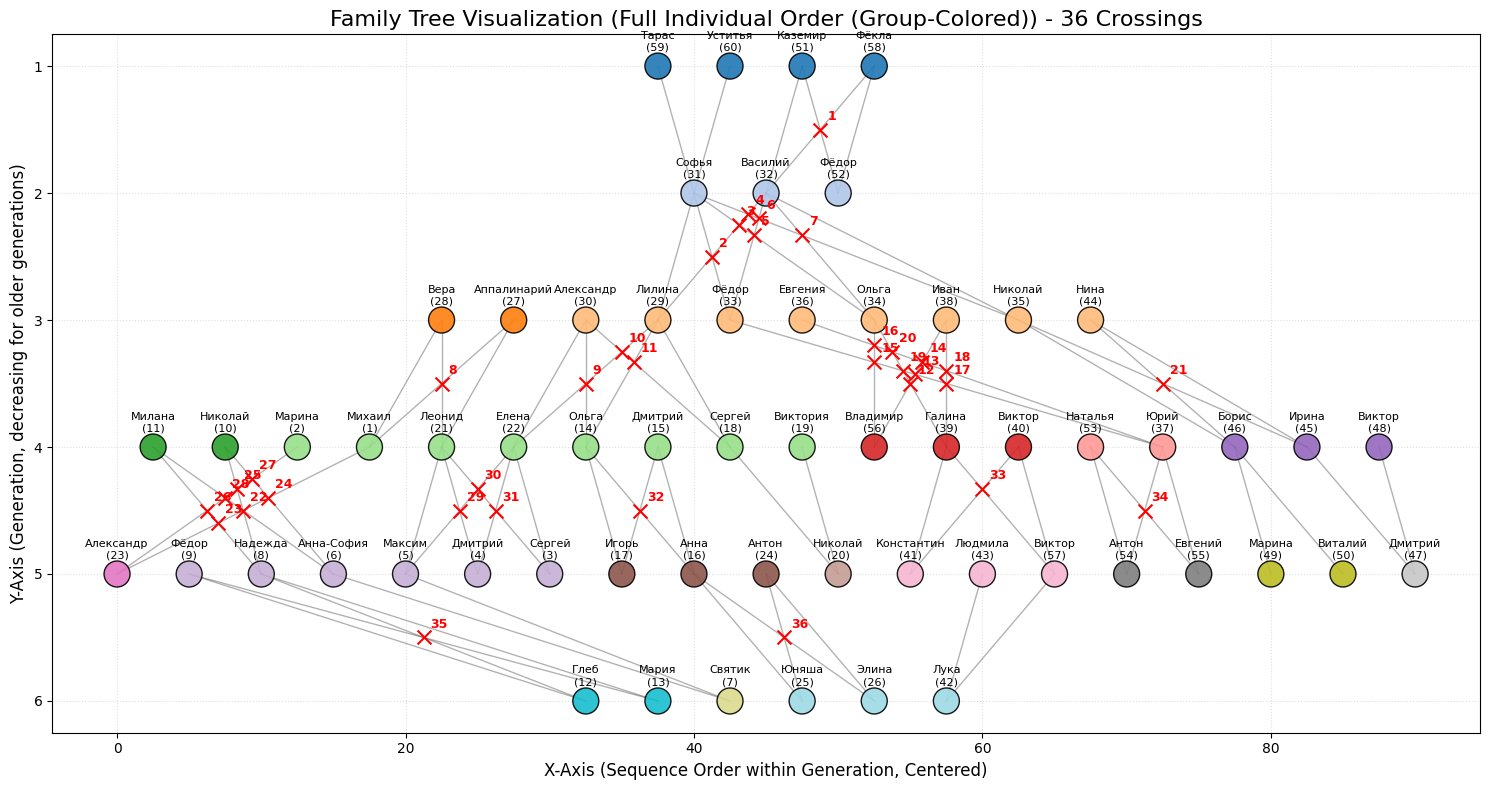

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import math
import json
import re
import os
from collections import defaultdict, OrderedDict

# --- File Definitions ---
# The primary change: manual_order_collapsed_regrouped.js is now expected 
# in the parent directory (..), not in data_sort/.
GROUP_ORDER_FILE_REGROUPED = os.path.join("..", "manual_order_collapsed_regrouped.js")
GROUP_ORDER_FILE_INITIAL = os.path.join("..", "manual_order_collapsed.js")
GROUP_VAR_NAME = "manualOrderCollapsed"

# The main file manual_order_regrouped.js is in the parent folder
FULL_ORDER_FILE_REGROUPED = os.path.join("..", "manual_order_regrouped.js")
FULL_ORDER_FILE_INITIAL = os.path.join("..", "manual_order.js")
FULL_VAR_NAME = "manualOrderFull"

# Set initial file paths to the 'regrouped' versions
GROUP_ORDER_FILE = GROUP_ORDER_FILE_REGROUPED
FULL_ORDER_FILE = FULL_ORDER_FILE_REGROUPED

# --- 1. Data Loading and Parsing Functions ---

def parse_js_order_file(filepath, var_name):
    """Reads a JS file containing a dictionary, cleans JS syntax, and parses it into a Python OrderedDict."""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
    except FileNotFoundError:
        print(f"File not found at '{filepath}'. Attempting next file if available...")
        return None

    # --- Robust Cleanup (Convert JS object notation to strict JSON) ---
    content = content.strip()
    
    # 1. Isolate the dictionary content by removing the JS variable declaration boilerplate
    start_pattern = f"const {var_name} = {{"
    
    if content.startswith(start_pattern) and content.endswith("};"):
        json_str = content[len(start_pattern):-2].strip() 
    else:
        print(f"Error: File content structure not recognized for variable '{var_name}' in {filepath}.")
        return None

    clean_lines = []
    for line in json_str.split('\n'):
        # Remove inline JS comments (//...)
        line = re.sub(r'\/\/.*', '', line).strip()
        # Remove the trailing comma (,) if it exists
        line = re.sub(r',$', '', line).strip()
        
        if line:
            clean_lines.append(line)
    
    # Join the clean lines back and wrap in braces to form valid JSON
    json_str_cleaned = "{" + ", ".join(clean_lines) + "}"

    # --- JSON Parsing ---
    try:
        data = json.loads(json_str_cleaned)
        
        # Convert string keys (generation numbers) to integers and convert PIDs from strings to integers
        parsed_data = OrderedDict({
            int(k): [int(v) for v in v_list]
            for k, v_list in data.items()
        })
        return parsed_data
    except json.JSONDecodeError as e:
        print(f"JSON Decoding Error in {filepath}: {e}")
        return None

# --- 2. Utility Function for Intersection Calculation ---

def calculate_intersection_point(P1_coord, C1_coord, P2_coord, C2_coord, y_parent, y_child):
    """Calculates the intersection point of two line segments spanning the same two generations."""
    x_p1, x_c1 = P1_coord[0], C1_coord[0]
    x_p2, x_c2 = P2_coord[0], C2_coord[0]

    if (x_p1 < x_p2 and x_c1 > x_c2) or (x_p1 > x_p2 and x_c1 < x_c2):
        denominator = (x_p1 - x_p2) - (x_c1 - x_c2)
        if abs(denominator) < 1e-9:
            return None 
        numerator = x_p1 - x_p2
        k = numerator / denominator
        
        if 0 < k < 1:
            x_i = x_p1 + k * (x_c1 - x_p1)
            y_i = y_parent + k * (y_child - y_parent)
            return (x_i, y_i)
            
    return None

# --- 3. Main Visualization Function ---

def generate_and_plot_tree(order_dict, title_suffix, is_group_plot, group_order):
    """
    Generates coordinates, finds links, calculates intersections, and plots 
    the family tree based on the provided generation order dictionary.
    
    :param order_dict: Dictionary mapping Generation -> [Ordered IDs]
    :param title_suffix: String to append to the plot title
    :param is_group_plot: True if plotting Group IDs, False if plotting Person IDs
    :param group_order: The dictionary of the group order (used for coloring the full plot)
    """
    
    # Check for necessary global variables
    if ('df' not in globals() or 'df_combined' not in globals() or 
        'PERSON_ID_COLUMN' not in globals() or 'PARENT_COLUMNS' not in globals() or 
        'NAME_RU_COLUMN' not in globals()):
        print("Error: Global DataFrames (df, df_combined) or column constants are missing.")
        return

    # --- 1. Prepare Plotting Data (Coordinates) ---
    X_SPACING_UNIT = 5
    plot_data = []
    global_color_index = 0
    
    # === 1a. Pre-calculate widths and find max_x for centering ===
    max_nodes = max((len(ids) for ids in order_dict.values()), default=0)
    max_width_x = (max_nodes - 1) * X_SPACING_UNIT 

    # Create a quick-lookup map for Group ID -> ColorIndex (for consistent coloring in the full plot)
    group_color_map = {}
    if group_order:
        for i, (gen, ids) in enumerate(sorted(group_order.items())):
            for group_id in ids:
                group_color_map[group_id] = global_color_index
                global_color_index += 1
    
    # Reset color index for the current plot (it will be re-used below)
    global_color_index = 0

    for gen, ordered_ids in sorted(order_dict.items()):
        y_coord = -gen * 10
        
        # Calculate offset to center this generation relative to max_width_x
        num_nodes = len(ordered_ids)
        current_width_x = (num_nodes - 1) * X_SPACING_UNIT
        centering_offset = (max_width_x - current_width_x) / 2 if max_nodes > 1 else 0

        x_position_index = 0
        
        # Source DataFrame for name lookups
        node_name_source = df_combined if is_group_plot else df
        
        for node_id in ordered_ids:
            node_id_int = int(node_id)
            row_match = node_name_source[node_name_source[PERSON_ID_COLUMN] == node_id_int]
            
            if not row_match.empty:
                row = row_match.iloc[0]
                
                if is_group_plot:
                    # Group Plot: Color each group uniquely in order
                    color_index = global_color_index
                    name_display = row.get(NAME_RU_COLUMN, f"Group {node_id}")
                    global_color_index += 1
                else:
                    # Full Plot: Color by the group the individual belongs to
                    color_index = gen # Fallback to gen
                    name_display = row.get(NAME_RU_COLUMN, f"ID {node_id}")
                    
                    # Find the group this individual belongs to for consistent coloring
                    group_match = df_combined[df_combined['OriginalGroupIDs'].apply(lambda x: node_id_int in x if isinstance(x, (list, tuple)) else False)]
                    if not group_match.empty:
                        group_id = group_match.iloc[0][PERSON_ID_COLUMN]
                        color_index = group_color_map.get(group_id, gen)
                        
                # Calculate the final centered X coordinate
                centered_x = centering_offset + x_position_index * X_SPACING_UNIT
                        
                plot_data.append({
                    'PersonID': node_id_int,
                    'Name-ru': name_display, 
                    'Generation': gen,
                    'x': centered_x, # <-- Use the centered X value
                    'y': y_coord,
                    'ColorIndex': color_index,
                })
                x_position_index += 1 

    plot_df = pd.DataFrame(plot_data)
    
    if plot_df.empty:
        print(f"No coordinate data to plot for {title_suffix}.")
        return


    # --- 2. Collect Segments (Links) and Coordinate Map ---
    all_segments = []
    intersection_points = []
    coord_map = plot_df.set_index('PersonID')[['x', 'y']].to_dict('index')
    
    # Set to track unique links (Parent Plot ID, Child Plot ID) to avoid duplicates
    unique_plotted_links = set()

    for _, row in plot_df.iterrows():
        child_id = row['PersonID'] # Plotted ID (Group ID or Person ID)
        
        # If we are plotting groups, we need the original PIDs within this group to find parents.
        if is_group_plot:
            group_match = df_combined[df_combined[PERSON_ID_COLUMN] == child_id]
            if group_match.empty: continue
            original_pids = group_match.iloc[0]['OriginalGroupIDs']
        else:
            original_pids = [child_id]
        
        # Iterate over all individuals represented by the child node/group
        for original_child_pid in original_pids:
            original_row_match = df[df[PERSON_ID_COLUMN] == original_child_pid]
            
            if original_row_match.empty: continue
            original_row = original_row_match.iloc[0]
            
            for parent_col in PARENT_COLUMNS:
                parent_pid_raw = original_row.get(parent_col)
                
                if pd.notna(parent_pid_raw):
                    parent_pid = int(parent_pid_raw)
                    
                    # Determine the parent's PLOTTED ID (Group ID or Person ID)
                    if is_group_plot:
                        parent_group_match = df_combined[df_combined['OriginalGroupIDs'].apply(lambda x: parent_pid in x if isinstance(x, (list, tuple)) else False)]
                        if parent_group_match.empty: continue
                        parent_plot_id = parent_group_match.iloc[0][PERSON_ID_COLUMN] # Group ID
                    else:
                        parent_plot_id = parent_pid # Person ID
                        
                    # 3. If both parent and child are plotted nodes
                    if parent_plot_id in coord_map and child_id in coord_map:
                        
                        # Add link only if it's unique
                        link_key = tuple(sorted((parent_plot_id, child_id)))
                        if link_key not in unique_plotted_links:
                            unique_plotted_links.add(link_key)
                            
                            p_coord = (coord_map[parent_plot_id]['x'], coord_map[parent_plot_id]['y'])
                            c_coord = (coord_map[child_id]['x'], coord_map[child_id]['y'])
                            
                            if p_coord[1] != c_coord[1]: # Only link across generations
                                all_segments.append({'P_ID': parent_plot_id, 'C_ID': child_id, 'P_COORD': p_coord, 'C_COORD': c_coord})
                            

    # --- 3. Find Intersections ---
    segments_by_gen_pair = defaultdict(list)
    for seg in all_segments:
        # Group segments by the Y-coordinate of the parent node
        segments_by_gen_pair[seg['P_COORD'][1]].append(seg)

    for y_parent, segments in segments_by_gen_pair.items():
        if len(segments) < 2: continue
        y_child = segments[0]['C_COORD'][1] 
        
        # Calculate intersections only on unique pairs of segments
        for seg_a, seg_b in itertools.combinations(segments, 2):
            intersection = calculate_intersection_point(seg_a['P_COORD'], seg_a['C_COORD'], 
                                                         seg_b['P_COORD'], seg_b['C_COORD'], 
                                                         y_parent, y_child)
            if intersection and intersection not in intersection_points:
                intersection_points.append(intersection)
                
    # --- 4. Create the Scatter Plot ---
    fig, ax = plt.subplots(figsize=(15, 8))

    # --- 4a. Draw Connections (Lines) ---
    for seg in all_segments:
        ax.plot([seg['C_COORD'][0], seg['P_COORD'][0]], [seg['C_COORD'][1], seg['P_COORD'][1]], 
                 'k-', alpha=0.3, linewidth=1, zorder=1) 

    # --- 4b. Draw Intersections ---
    total_crossings = len(intersection_points)
    if intersection_points:
        ix_x = [p[0] for p in intersection_points]
        ix_y = [p[1] for p in intersection_points]
        ax.scatter(ix_x, ix_y, c='red', marker='x', s=100, 
                    label=f'{total_crossings} Crossings', zorder=3)
        
        # Annotate with numbers
        for i, (x_i, y_i) in enumerate(intersection_points):
            ax.annotate(str(i + 1), (x_i, y_i), textcoords="offset points", xytext=(5, 5), 
                         ha='left', va='bottom', fontsize=9, color='red', fontweight='bold', zorder=4)

    # --- 4c. Draw Nodes (Points) ---
    ax.scatter(plot_df['x'], plot_df['y'],
               c=plot_df['ColorIndex'], cmap='tab20', s=350, 
               alpha=0.9, edgecolors='black', linewidths=1.0, zorder=2)

    # --- 5. Add Annotations: Name and PersonID ---
    for _, row in plot_df.iterrows():
        ax.annotate(
            f"{row['Name-ru']}\n({row['PersonID']})", 
            (row['x'], row['y']),
            textcoords="offset points", xytext=(0, 10), ha='center', va='bottom', 
            fontsize=8, color='black'
        )

    # --- 6. Final Touches ---
    plt.title(f"Family Tree Visualization ({title_suffix}) - {total_crossings} Crossings", fontsize=16)
    plt.xlabel("X-Axis (Sequence Order within Generation, Centered)", fontsize=12)
    plt.ylabel("Y-Axis (Generation, decreasing for older generations)", fontsize=12)

    ax.set_aspect('auto', adjustable='box') 
    ax.grid(True, linestyle=':', alpha=0.4)
    if not plot_df.empty:
        ax.set_yticks(sorted(plot_df['y'].unique()))
        ax.set_yticklabels(sorted(plot_df['Generation'].unique(), reverse=True))
    
    # Legend removed as node colors represent non-labelable indices

    plt.tight_layout()
    # plt.show() # NOTE: Commented out to prevent blocking in an environment without a display

# ====================================================================
# --- Combined Execution (Final Logic) ---
# ====================================================================

# 1. Load Orders (Attempt 1: _regrouped files)
print(f"--- Attempting to load regrouped files: {GROUP_ORDER_FILE} and {FULL_ORDER_FILE} ---")
group_order = parse_js_order_file(GROUP_ORDER_FILE, GROUP_VAR_NAME)
full_order = parse_js_order_file(FULL_ORDER_FILE, FULL_VAR_NAME)

# 2. Check and Fallback to Initial Files (Attempt 2)
if group_order is None:
    print("\nRegrouped files not found or failed to load. Falling back to initial files...")
    
    # Reset file paths to initial files
    GROUP_ORDER_FILE = GROUP_ORDER_FILE_INITIAL
    FULL_ORDER_FILE = FULL_ORDER_FILE_INITIAL
    
    # Reload orders with initial files
    print(f"--- Attempting to load initial files: {GROUP_ORDER_FILE} and {FULL_ORDER_FILE} ---")
    group_order = parse_js_order_file(GROUP_ORDER_FILE, GROUP_VAR_NAME)
    full_order = parse_js_order_file(FULL_ORDER_FILE, FULL_VAR_NAME)
    
# 3. Textual Summary
print("="*80)
# Use the final successful file path for reporting, or the regrouped path if both failed
loaded_group_file = GROUP_ORDER_FILE if group_order else GROUP_ORDER_FILE_REGROUPED
loaded_full_file = FULL_ORDER_FILE if full_order else FULL_ORDER_FILE_REGROUPED

print(f"--- Loading and Displaying Group Order ({loaded_group_file}) ---")
if group_order:
    for gen, ids in group_order.items():
        print(f"\nGeneration {gen} (Groups, Total: {len(ids)}):")
        display_ids = [str(i) for i in ids]
        display_str = " -> ".join(display_ids[:10])
        
        if len(ids) > 10:
            display_str += f" ... (and {len(ids) - 10} more Group IDs)"
            
        print("   " + display_str)
else:
    print("Group order not loaded (File not found or parsing error after all attempts).")

print("\n" + "="*80 + "\n")

print(f"--- Loading and Displaying Full Person Order ({loaded_full_file}) ---")

if full_order:
    for gen, ids in full_order.items():
        print(f"\nGeneration {gen} (Individuals, Total: {len(ids)}):")
        display_ids = [str(i) for i in ids]
        display_str = " -> ".join(display_ids[:20])
        
        if len(ids) > 20:
            display_str += f" ... (and {len(ids) - 20} more PIDs)"
            
        print("   " + display_str)

print("\n" + "="*80 + "\n")

# 4. Plotting
# NOTE: Group plotting is still skipped as per the original modification request.

if full_order:
    print("Generating Plot: Full Individual Order (Group-Colored)")
    # Pass group_order so individuals are colored by their group
    generate_and_plot_tree(full_order, "Full Individual Order (Group-Colored)", False, group_order) 
else:
    print("Skipping Plot: 'full_order' not loaded.")

### Cell 4 - calculation of new coordinate based on the in-generation relationships ###

In [12]:
import pandas as pd
import numpy as np
from collections import defaultdict, OrderedDict
import itertools 

# --- 1. Define Gap Parameters ---
spouseGap = 1.0  # Closest spacing (1.0)
siblingGap = spouseGap * 1.2  # Sibling gap (1.5)
groupGap = spouseGap * 1.4   # Group gap (1.7)
nodeGap = spouseGap * 1.9    # Default/Node gap (1.9)

# Placeholder for the spouse column name
SPOUSE_COLUMN = 'PartnerID' 

# --- 2. Relationship Helper Functions ---

def get_siblings(pid, df, parent_cols):
    """Finds all Person IDs (PIDs) who share at least one parent with the given PID."""
    row = df[df[PERSON_ID_COLUMN] == pid]
    if row.empty:
        return set()
    
    parent_pids = [int(row.iloc[0].get(col)) for col in parent_cols if pd.notna(row.iloc[0].get(col))]
    if not parent_pids:
        return set()
    
    sibling_pids = df[df[parent_cols].apply(lambda x: any(int(p) in parent_pids for p in x.dropna()), axis=1)][PERSON_ID_COLUMN].tolist()
    
    return set(int(s) for s in sibling_pids if s != pid)

def get_spouse(pid, df):
    """Finds the spouse of a given PID."""
    if SPOUSE_COLUMN not in df.columns:
        return None

    row = df[df[PERSON_ID_COLUMN] == pid]
    if row.empty:
        return None
        
    spouse_pid = row.iloc[0].get(SPOUSE_COLUMN)
    return int(spouse_pid) if pd.notna(spouse_pid) else None

def get_group_id(pid, df_combined):
    """Finds the Group ID a person belongs to."""
    group_match = df_combined[df_combined['OriginalGroupIDs'].apply(lambda x: pid in x if isinstance(x, (list, tuple)) else False)]
    if not group_match.empty:
        return group_match.iloc[0][PERSON_ID_COLUMN]
    return None

# --- 3. Dynamic Coordinate Function ---

def get_dynamic_coordinates(order_dict, df, df_combined, parent_cols, group_order=None):
    """
    Calculates coordinates using dynamic spacing and centers each generation 
    by subtracting the mean X-coordinate of that generation.
    """
    
    gen_x_coords = {}
    group_color_map = {}
    global_color_index = 0
    if group_order:
        for i, (gen, ids) in enumerate(sorted(group_order.items())):
            for group_id in ids:
                group_color_map[group_id] = global_color_index
                global_color_index += 1
    
    
    print("\n--- Dynamic Coordinate Calculation (Centering by Mean) ---")
    print(f"Gaps: Spouse={spouseGap:.1f}, Sibling={siblingGap:.1f}, Group={groupGap:.1f}, Default={nodeGap:.1f}")

    # --- PHASE 1: Calculate Raw X ---
    for gen, ordered_ids in sorted(order_dict.items()):
        y_coord = -gen * 10
        current_x = 0.0
        generation_coords = []
        previous_pid = None
        
        # Calculate raw X-coordinates
        for i, current_pid in enumerate(ordered_ids):
            current_pid = int(current_pid)
            gap_type = "First" 
            gap = 0.0
            
            if i == 0:
                current_x = 0.0
            else:
                # --- Determine Relationship and Gap (Prioritized) ---
                
                # 1. Spouse Check (Highest Priority)
                if (get_spouse(current_pid, df) == previous_pid or 
                    get_spouse(previous_pid, df) == current_pid):
                    gap = spouseGap
                    gap_type = "Spouse"
                
                # 2. Sibling Check (Next Priority)
                elif current_pid in get_siblings(previous_pid, df, parent_cols):
                    gap = siblingGap
                    gap_type = "Sibling"
                
                # 3. Same Group Check
                elif get_group_id(current_pid, df_combined) == get_group_id(previous_pid, df_combined):
                    gap = groupGap
                    gap_type = "Group"
                
                # 4. Default Gap
                else:
                    gap = nodeGap
                    gap_type = "Node"
                
                current_x += gap
            
            # --- Determine Color Index and Store RAW Data ---
            color_index = group_color_map.get(get_group_id(current_pid, df_combined), gen)
            
            row_match = df[df[PERSON_ID_COLUMN] == current_pid]
            name_display = row_match.iloc[0].get(NAME_RU_COLUMN, f"ID {current_pid}") if not row_match.empty else f"ID {current_pid}"

            plot_data_entry = {
                'PersonID': current_pid, 'Name-ru': name_display, 'Generation': gen,
                'x_raw': current_x, 'y': y_coord, 'ColorIndex': color_index,
                'gap_type': gap_type, 'gap_value': gap, 
                'previous_pid': previous_pid 
            }
            generation_coords.append(plot_data_entry) 
            previous_pid = current_pid
            
        gen_x_coords[gen] = generation_coords
        
    # --- PHASE 2: Apply Centering by Subtracting Mean X and Print ---
    all_plot_data = []

    print("\n--- Applying Mean Centering Offset and Final Coordinates ---")
    
    for gen, coords_list in gen_x_coords.items():
        if not coords_list: continue
        
        raw_x_values = [entry['x_raw'] for entry in coords_list]
        mean_x = np.mean(raw_x_values)
        
        print(f"\nGeneration {gen}: Mean X={mean_x:.2f}, Final X Range: [{(raw_x_values[0] - mean_x):.2f}, {(raw_x_values[-1] - mean_x):.2f}]")

        for i, entry in enumerate(coords_list):
            
            centered_x = entry['x_raw'] - mean_x
            
            # Print the detailed coordinate information
            if i > 0:
                print(f"  ID {entry['PersonID']}: Centered X={centered_x:.2f} (Gap from {entry['previous_pid']}: {entry['gap_type']} = {entry['gap_value']:.1f})")
            else:
                 print(f"  ID {entry['PersonID']}: Centered X={centered_x:.2f} (First node)")
            
            entry['x'] = centered_x 
            
            # Clean up temporary keys before finalizing
            del entry['x_raw']
            del entry['gap_type']
            del entry['gap_value']
            del entry['previous_pid']
            
            all_plot_data.append(entry)

    return pd.DataFrame(all_plot_data)

# --- Execution ---
if 'full_order' in globals() and full_order:
    plot_df_dynamic = get_dynamic_coordinates(
        order_dict=full_order, df=df, df_combined=df_combined, 
        parent_cols=PARENT_COLUMNS, group_order=group_order
    )
    print("\n\n--- Dynamic Coordinate Calculation Complete (Mean Centered) ---")
    print(f"DataFrame 'plot_df_dynamic' is ready for plotting with {len(plot_df_dynamic)} nodes.")
else:
    print("Error: 'full_order' is not loaded. Cannot calculate dynamic coordinates.")

# Intersection helper function definition (for the next cell)
def calculate_intersection_point(P1_coord, C1_coord, P2_coord, C2_coord, y_parent, y_child):
    """Calculates the intersection point of two line segments spanning the same two generations."""
    x_p1, x_c1 = P1_coord[0], C1_coord[0]
    x_p2, x_c2 = P2_coord[0], C2_coord[0]

    if (x_p1 < x_p2 and x_c1 > x_c2) or (x_p1 > x_p2 and x_c1 < x_c2):
        denominator = (x_p1 - x_p2) - (x_c1 - x_c2)
        if abs(denominator) < 1e-9:
            return None 
        numerator = x_p1 - x_p2
        k = numerator / denominator
        
        if 0 < k < 1:
            x_i = x_p1 + k * (x_c1 - x_p1)
            y_i = y_parent + k * (y_child - y_parent)
            return (x_i, y_i)
            
    return None


--- Dynamic Coordinate Calculation (Centering by Mean) ---
Gaps: Spouse=1.0, Sibling=1.2, Group=1.4, Default=1.9

--- Applying Mean Centering Offset and Final Coordinates ---

Generation 1: Mean X=1.95, Final X Range: [-1.95, 1.95]
  ID 59: Centered X=-1.95 (First node)
  ID 60: Centered X=-0.95 (Gap from 59: Spouse = 1.0)
  ID 51: Centered X=0.95 (Gap from 60: Node = 1.9)
  ID 58: Centered X=1.95 (Gap from 51: Spouse = 1.0)

Generation 2: Mean X=1.07, Final X Range: [-1.07, 1.13]
  ID 31: Centered X=-1.07 (First node)
  ID 32: Centered X=-0.07 (Gap from 31: Spouse = 1.0)
  ID 52: Centered X=1.13 (Gap from 32: Sibling = 1.2)

Generation 3: Mean X=5.58, Final X Range: [-5.58, 5.32]
  ID 28: Centered X=-5.58 (First node)
  ID 27: Centered X=-4.58 (Gap from 28: Spouse = 1.0)
  ID 30: Centered X=-2.68 (Gap from 27: Node = 1.9)
  ID 29: Centered X=-1.68 (Gap from 30: Spouse = 1.0)
  ID 33: Centered X=-0.48 (Gap from 29: Sibling = 1.2)
  ID 36: Centered X=0.52 (Gap from 33: Spouse = 1.0)
  

### Cell 4b - centering children ###

In [13]:
# This cell assumes that 'plot_df_dynamic', 'df', 'PARENT_COLUMNS', 'PERSON_ID_COLUMN', 
# 'SPOUSE_COLUMN', 'nodeGap', the helper function 'get_group_id', and the DataFrame 
# 'df_combined' (used by get_group_id) are defined from the previous cells.

# 1. Define the minimum separation distance based on the existing nodeGap
# NOTE: The user's provided constraint is nodeGap * 0.8
MIN_SEPARATION_DISTANCE = np.maximum(nodeGap * 0.5, spouseGap*1.1)
MAX_ITERATIONS = 5

print(f"--- Starting Refinement Process: Constraint={MIN_SEPARATION_DISTANCE:.2f} (nodeGap * 0.8) ---")

def refine_coordinates_iteratively(df_plot, df_individual, parent_cols, iterations):
    """
    Selectively refines coordinates for single-person and two-person groups 
    based on connected nodes, subject to a minimum separation constraint,
    moving groups as rigid units.
    
    NOTE: This function assumes 'get_group_id' and 'df_combined' (from the initial 
    grouping step) are available in the global scope to accurately determine the 
    original group size.
    """
    
    # 1. Initialize link map and coordinate cache
    link_map = {}
    
    # Use a dictionary for fast coordinate lookup and update during iterations
    coords_map = df_plot.set_index(PERSON_ID_COLUMN)['x'].to_dict()
    
    # --- A. Build Link Map (Parents/Children) ---
    for pid in df_plot[PERSON_ID_COLUMN]:
        pid = int(pid)
        link_map[pid] = {'parents': [], 'children': []}
        
        # Find Parents
        row = df_individual[df_individual[PERSON_ID_COLUMN] == pid]
        if not row.empty:
            for col in parent_cols:
                parent_pid_raw = row.iloc[0].get(col)
                if pd.notna(parent_pid_raw):
                    parent_pid = int(parent_pid_raw)
                    # Only consider connections to nodes that are also in the plotting set
                    if parent_pid in df_plot[PERSON_ID_COLUMN].values:
                        link_map[pid]['parents'].append(parent_pid)

    # Find Children (by iterating through parents who are in the plotting set)
    for child_pid in df_plot[PERSON_ID_COLUMN]:
        child_pid = int(child_pid)
        row = df_individual[df_individual[PERSON_ID_COLUMN] == child_pid]
        if not row.empty:
            for col in parent_cols:
                parent_pid_raw = row.iloc[0].get(col)
                if pd.notna(parent_pid_raw):
                    parent_pid = int(parent_pid_raw)
                    if parent_pid in link_map:
                        if child_pid not in link_map[parent_pid]['children']:
                            link_map[parent_pid]['children'].append(child_pid)
                            
    # --- B. Determine Eligible Groups (Size 1 or 2 Check) ---
    pid_to_group_id = {}
    group_members_in_plot = defaultdict(list)
    pid_group_size = {}

    # Map PIDs to their group leader and collect members in plot
    for pid in df_plot[PERSON_ID_COLUMN]:
        pid = int(pid)
        group_id = get_group_id(pid, df_combined) 
        
        # If no group found in df_combined, treat as a single-person group led by itself
        leader_id = group_id if group_id else pid
        
        pid_to_group_id[pid] = leader_id
        group_members_in_plot[leader_id].append(pid)
        
        if leader_id not in pid_group_size:
            if group_id:
                # Calculate original size from df_combined
                group_row = df_combined[df_combined[PERSON_ID_COLUMN] == group_id]
                pid_group_size[leader_id] = len(group_row.iloc[0]['OriginalGroupIDs']) if not group_row.empty and 'OriginalGroupIDs' in group_row.columns else 1
            else:
                pid_group_size[leader_id] = 1 # Single node not found in any group
            
    eligible_groups = {} # {group_leader_pid: [member_pids]}
    
    for group_id, members in group_members_in_plot.items():
        original_size = pid_group_size.get(group_id, 1)

        # Check 1: Is the group size 1 OR 2?
        if original_size in (1, 2):
            
            # Check 2: Does the group have up or down connections? (Check connections of ANY member)
            has_connections = False
            for member_pid in members:
                if link_map.get(member_pid, {}).get('parents') or link_map.get(member_pid, {}).get('children'):
                    has_connections = True
                    break
            
            if has_connections:
                eligible_groups[group_id] = members

    print(f"\nIdentified {len(eligible_groups)} groups (size 1 or 2) eligible for refinement:")
    print(f"Eligible Group Leaders: {sorted(list(eligible_groups.keys()))}")
    
    # 2. Iteratively update and separate coordinates
    print(f"\n--- Starting Iterative Refinement ({iterations} iterations) ---")
    
    for iteration in range(iterations):
        total_movement = 0.0
        
        # Get an updated list of all PIDs grouped by generation, sorted by current X (needed for neighbor check)
        gen_groups = df_plot.groupby('Generation')[PERSON_ID_COLUMN].apply(list).to_dict()
        sorted_gen_pids = {gen: sorted(pids, key=lambda pid: coords_map[pid]) 
                           for gen, pids in gen_groups.items()}
        
        # Process eligible Groups
        for group_id, member_pids in eligible_groups.items():
            
            # 1. Calculate Group Center (Current)
            current_x_values = [coords_map[pid] for pid in member_pids]
            current_center_x = np.mean(current_x_values)
            
            # 2. Calculate Target Center X (Mean of Connected Nodes)
            connected_x_values = []
            for member_pid in member_pids:
                # Aggregate connections from all members in the group
                for conn_pid in link_map[member_pid]['parents'] + link_map[member_pid]['children']:
                    connected_x_values.append(coords_map.get(conn_pid, current_center_x))
            
            if not connected_x_values: continue
            
            target_center_x = np.mean(connected_x_values)
            desired_shift = target_center_x - current_center_x
            
            # 3. Determine Group Boundaries and Neighbors
            
            # Sort members by X-coordinate to find boundaries (important for group of 2)
            member_pids.sort(key=lambda pid: coords_map[pid])
            leftmost_pid = member_pids[0]
            rightmost_pid = member_pids[-1]
            
            # Get generation details
            gen = df_plot.loc[df_plot[PERSON_ID_COLUMN] == leftmost_pid, 'Generation'].iloc[0]
            sorted_pids_in_gen = sorted_gen_pids[gen] 
            
            # Find the group's index range in the generation
            min_index = sorted_pids_in_gen.index(leftmost_pid)
            max_index = sorted_pids_in_gen.index(rightmost_pid)

            # Initial shift limits
            max_left_shift = desired_shift
            max_right_shift = desired_shift

            # --- C. Separation Constraint Check ---
            
            # 1. Check Left Neighbor of the leftmost_pid
            if min_index > 0:
                prev_pid = sorted_pids_in_gen[min_index - 1]
                prev_x = coords_map[prev_pid]
                
                # X position of the leftmost node * after* the desired shift
                new_left_x_desired = coords_map[leftmost_pid] + desired_shift
                
                # Max X allowed for the leftmost node (constrained by neighbor's position)
                max_allowed_x_left = prev_x + MIN_SEPARATION_DISTANCE 
                
                # If the move causes a left collision (new X is less than the minimum allowed X)
                if new_left_x_desired < max_allowed_x_left:
                    # Constrained shift is the distance from current X to the maximum allowed X
                    max_left_shift = max_allowed_x_left - coords_map[leftmost_pid]
            
            # 2. Check Right Neighbor of the rightmost_pid
            if max_index < len(sorted_pids_in_gen) - 1:
                next_pid = sorted_pids_in_gen[max_index + 1]
                next_x = coords_map[next_pid]
                
                # X position of the rightmost node * after* the desired shift
                new_right_x_desired = coords_map[rightmost_pid] + desired_shift
                
                # Min X allowed for the rightmost node (constrained by neighbor's position)
                min_allowed_x_right = next_x - MIN_SEPARATION_DISTANCE
                
                # If the move causes a right collision (new X is greater than the maximum allowed X)
                if new_right_x_desired > min_allowed_x_right:
                    # Constrained shift is the distance from current X to the minimum allowed X
                    max_right_shift = min_allowed_x_right - coords_map[rightmost_pid]

            # 4. Final Confined Shift
            if desired_shift > 0:
                # Moving right: constrained by max_right_shift
                actual_shift = min(desired_shift, max_right_shift)
            else: # desired_shift <= 0 (Moving left or staying put)
                # Moving left: constrained by max_left_shift
                actual_shift = max(desired_shift, max_left_shift)
            
            # 5. Apply the actual shift to ALL group members
            if abs(actual_shift) > 1e-6:
                for pid in member_pids:
                    coords_map[pid] += actual_shift
                    total_movement += abs(actual_shift)

                print(f"  Group {group_id} (Size {len(member_pids)}): Shifted X by {actual_shift:.4f} (Desired: {desired_shift:.4f})")

        print(f"Iteration {iteration + 1}: Total Absolute Movement = {total_movement:.4f}")
        
        # Check for convergence
        if total_movement < 1e-4 and iteration > 0:
            print("Convergence reached. Stopping iteration early.")
            break

    # 3. Update the DataFrame with the final positions
    print("\nApplying final refined coordinates to 'plot_df_dynamic'.")
    for pid, x_coord in coords_map.items():
        df_plot.loc[df_plot[PERSON_ID_COLUMN] == pid, 'x'] = x_coord
        
    return df_plot

# --- Execution ---
if 'plot_df_dynamic' in globals():
    plot_df_dynamic = refine_coordinates_iteratively(
        df_plot=plot_df_dynamic, 
        df_individual=df, 
        parent_cols=PARENT_COLUMNS, 
        iterations=MAX_ITERATIONS
    )
    print("\n\n--- Selective Refinement Complete ---")
    print(f"DataFrame 'plot_df_dynamic' has been updated with refined coordinates.")
else:
    print("Error: 'plot_df_dynamic' is not loaded. Please run the previous cell first.")


--- Starting Refinement Process: Constraint=1.10 (nodeGap * 0.8) ---

Identified 14 groups (size 1 or 2) eligible for refinement:
Eligible Group Leaders: [np.int64(1060), np.int64(1061), np.int64(1062), np.int64(1063), np.int64(1066), np.int64(1067), np.int64(1069), np.int64(1070), np.int64(1071), np.int64(1073), np.int64(1074), np.int64(1077), np.int64(1080), np.int64(1081)]

--- Starting Iterative Refinement (5 iterations) ---
  Group 1081 (Size 2): Shifted X by 0.3833 (Desired: 0.3833)
  Group 1080 (Size 2): Shifted X by -0.4167 (Desired: -0.9167)
  Group 1077 (Size 2): Shifted X by -1.1311 (Desired: -1.1311)
  Group 1073 (Size 2): Shifted X by 0.8000 (Desired: 1.2795)
  Group 1074 (Size 2): Shifted X by -0.8000 (Desired: -1.2366)
  Group 1067 (Size 1): Shifted X by 0.8000 (Desired: 5.1205)
  Group 1066 (Size 1): Shifted X by -0.8000 (Desired: -1.5795)
  Group 1071 (Size 2): Shifted X by -0.8000 (Desired: -2.1795)
  Group 1070 (Size 2): Shifted X by -1.6000 (Desired: -2.0795)
  Grou

### Cell 5 - visualization of the current alignment ###

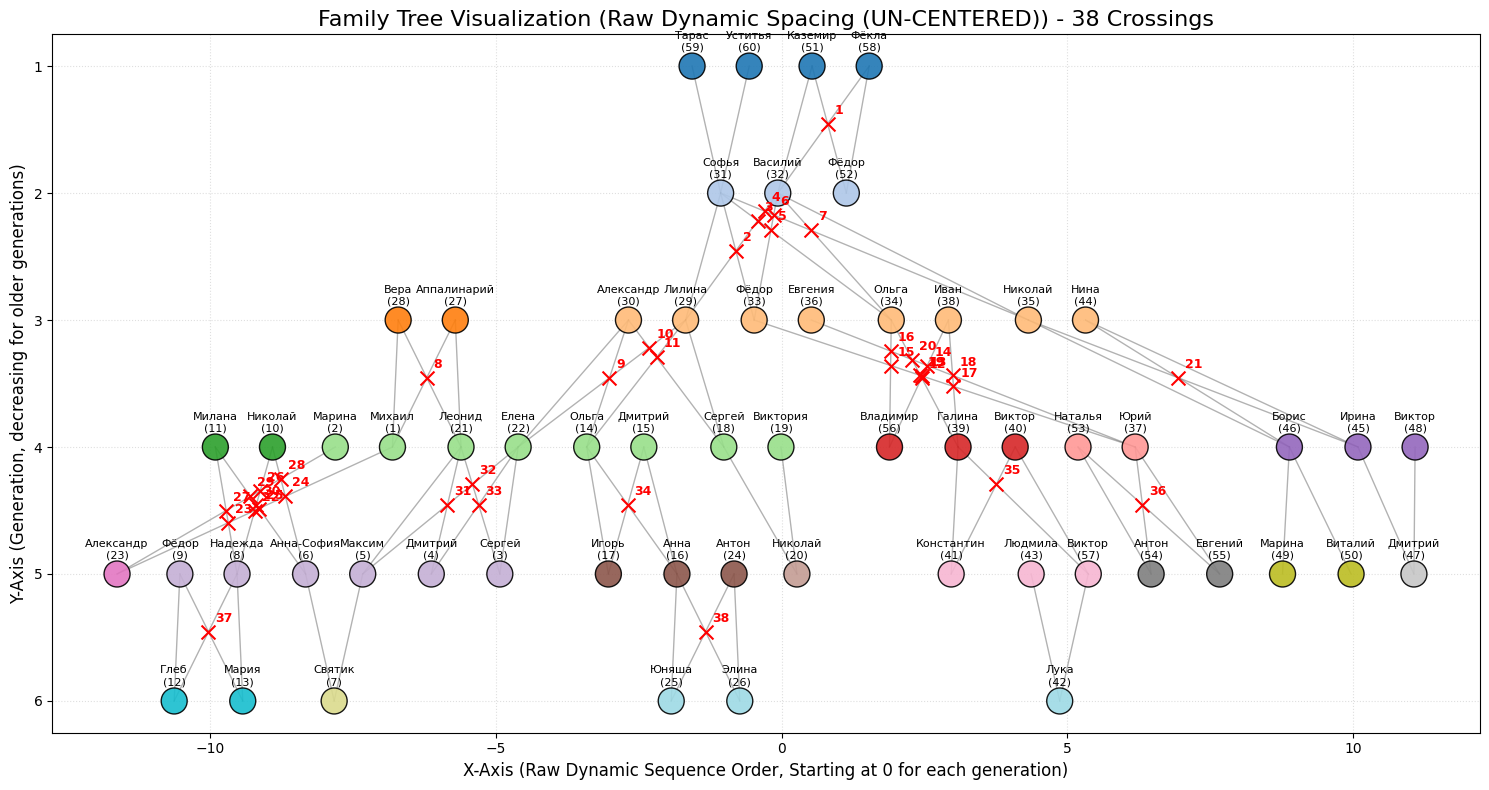

In [14]:
import matplotlib.pyplot as plt
import itertools
import math
import pandas as pd

if 'plot_df_dynamic' not in globals() or plot_df_dynamic.empty:
    print("Error: 'plot_df_dynamic' not found or is empty. Run Cell 1 first.")

else:
    plot_df = plot_df_dynamic
    
    # --- 1. Collect Segments (Links) and Coordinate Map ---
    all_segments = []
    intersection_points = []
    coord_map = plot_df.set_index('PersonID')[['x', 'y']].to_dict('index')
    unique_plotted_links = set()

    for _, row in plot_df.iterrows():
        child_id = row['PersonID']
        
        # Look up parent info from the original df (individual data)
        original_row_match = df[df[PERSON_ID_COLUMN] == child_id]
        if original_row_match.empty: continue
        original_row = original_row_match.iloc[0]
        
        for parent_col in PARENT_COLUMNS:
            parent_pid_raw = original_row.get(parent_col)
            
            if pd.notna(parent_pid_raw):
                parent_plot_id = int(parent_pid_raw)
                
                # Check if parent node exists and is plotted
                if parent_plot_id in coord_map and child_id in coord_map:
                    link_key = tuple(sorted((parent_plot_id, child_id)))
                    if link_key not in unique_plotted_links:
                        unique_plotted_links.add(link_key)
                        
                        p_coord = (coord_map[parent_plot_id]['x'], coord_map[parent_plot_id]['y'])
                        c_coord = (coord_map[child_id]['x'], coord_map[child_id]['y'])
                        
                        if p_coord[1] != c_coord[1]: # Only link across generations
                            all_segments.append({'P_ID': parent_plot_id, 'C_ID': child_id, 'P_COORD': p_coord, 'C_COORD': c_coord})
                        

    # --- 2. Find Intersections (Reusing original logic) ---
    segments_by_gen_pair = defaultdict(list)
    for seg in all_segments:
        segments_by_gen_pair[seg['P_COORD'][1]].append(seg)

    for y_parent, segments in segments_by_gen_pair.items():
        if len(segments) < 2: continue
        y_child = segments[0]['C_COORD'][1] 
        
        for seg_a, seg_b in itertools.combinations(segments, 2):
            intersection = calculate_intersection_point(seg_a['P_COORD'], seg_a['C_COORD'], 
                                                         seg_b['P_COORD'], seg_b['C_COORD'], 
                                                         y_parent, y_child)
            if intersection and intersection not in intersection_points:
                intersection_points.append(intersection)
                
    total_crossings = len(intersection_points)

    # --- 3. Create the Plot ---
    fig, ax = plt.subplots(figsize=(15, 8))

    # --- 3a. Draw Connections (Lines) ---
    for seg in all_segments:
        ax.plot([seg['C_COORD'][0], seg['P_COORD'][0]], [seg['C_COORD'][1], seg['P_COORD'][1]], 
                 'k-', alpha=0.3, linewidth=1, zorder=1) 

    # --- 3b. Draw Intersections ---
    if intersection_points:
        ix_x = [p[0] for p in intersection_points]
        ix_y = [p[1] for p in intersection_points]
        ax.scatter(ix_x, ix_y, c='red', marker='x', s=100, 
                    label=f'{total_crossings} Crossings', zorder=3)
        
        for i, (x_i, y_i) in enumerate(intersection_points):
            ax.annotate(str(i + 1), (x_i, y_i), textcoords="offset points", xytext=(5, 5), 
                         ha='left', va='bottom', fontsize=9, color='red', fontweight='bold', zorder=4)

    # --- 3c. Draw Nodes (Points) ---
    ax.scatter(plot_df['x'], plot_df['y'],
               c=plot_df['ColorIndex'], cmap='tab20', s=350, 
               alpha=0.9, edgecolors='black', linewidths=1.0, zorder=2)

    # --- 4. Add Annotations: Name and PersonID ---
    for _, row in plot_df.iterrows():
        ax.annotate(
            f"{row['Name-ru']}\n({row['PersonID']})", 
            (row['x'], row['y']),
            textcoords="offset points", xytext=(0, 10), ha='center', va='bottom', 
            fontsize=8, color='black'
        )

    # --- 5. Final Touches ---
    title_suffix = "Raw Dynamic Spacing (UN-CENTERED)"
    plt.title(f"Family Tree Visualization ({title_suffix}) - {total_crossings} Crossings", fontsize=16)
    
    # Update X-axis label to reflect raw coordinates
    plt.xlabel("X-Axis (Raw Dynamic Sequence Order, Starting at 0 for each generation)", fontsize=12)
    plt.ylabel("Y-Axis (Generation, decreasing for older generations)", fontsize=12)

    ax.set_aspect('auto', adjustable='box') 
    ax.grid(True, linestyle=':', alpha=0.4)
    if not plot_df.empty:
        ax.set_yticks(sorted(plot_df['y'].unique()))
        ax.set_yticklabels(sorted(plot_df['Generation'].unique(), reverse=True))

    plt.tight_layout()
    plt.show()

### Cell 6 - save the coordinates ###

In [15]:
# ====================================================================
# New Save Script — Save Optimized Final X-Coordinates
# ====================================================================

from collections import OrderedDict, defaultdict
import os 
import pandas as pd # Ensure pandas is imported if not globally available
import numpy as np # Ensure numpy is imported if not globally available

# --- File paths configured for the parent folder ---
PARENT_DIR = os.path.pardir # Represents '..'
OUTPUT_FILE_X_COORDS = os.path.join(PARENT_DIR, "final_x_coordinates.js")

# --- Helper function to save JS coordinate object nicely ---
def save_js_x_coords(filename, var_name, data_dict, comment_template):
    """
    Saves an OrderedDict ({gen: {pid: x}}) as a nicely formatted JS object file.
    The output contains only the generation number and an array of X-coordinates
    (ordered left-to-right).

    Args:
        filename (str): output JS file path (now points to parent directory)
        var_name (str): JS variable name
        data_dict (OrderedDict): {generation_number: {pid: x_coord}}
        comment_template (str): template for comments per generation
    """
    try:
        with open(filename, "w", encoding="utf-8") as f:
            f.write(f"const {var_name} = {{\n")
            total_gens = len(data_dict)
            
            for idx, (gen_num, coords_map) in enumerate(data_dict.items(), 1):
                comment = comment_template.format(gen_num=gen_num)
                comma = ',' if idx < total_gens else ''
                
                # Build the list of coordinate strings: 'x.xxxx'
                # The coordinates are retrieved in their sorted, left-to-right order
                coord_lines = []
                for x_coord in coords_map.values():
                    # Output coordinate rounded to 4 decimal places
                    coord_lines.append(f'{x_coord:.4f}')

                # Write the entire generation's coordinates as a JS array on a single line
                f.write(f'  "{gen_num}": [ {", ".join(coord_lines)} ]{comma}{comment}\n')
                
            f.write("};\n")
        print(f"✅ Successfully saved '{os.path.basename(filename)}' in the parent folder ({PARENT_DIR}).")
    except Exception as e:
        print(f"❌ ERROR saving file '{filename}': {e}")


# --- 1. Prepare and Print Final X-Coordinates ---
if 'plot_df_dynamic' in globals():
    
    # Extract PID, Generation, and X-coordinate
    df_x_coords = plot_df_dynamic[[PERSON_ID_COLUMN, 'Generation', 'x']].copy()
    
    # Group by generation and create the inner {pid: x} map
    # Using defaultdict(OrderedDict) preserves the order when built from the sorted DataFrame
    x_coords_by_gen = defaultdict(OrderedDict)
    
    # Sort the DataFrame by Generation and then by X-coordinate (left to right) for clean print order
    df_x_coords = df_x_coords.sort_values(by=['Generation', 'x'])

    # --- Shift coordinates so all are non-negative ---
    min_x = df_x_coords['x'].min()
    if min_x < 0:
        df_x_coords['x'] = df_x_coords['x'] - min_x
        print(f"⚙️ Shifted all X-coordinates by {-min_x:.4f} to remove negatives.")

    
    for _, row in df_x_coords.iterrows():
        # Ensure types are correct for dictionary keys
        gen = int(row['Generation'])
        pid = int(row[PERSON_ID_COLUMN])
        x_coord = row['x']
        # Use PID as key and X-coordinate as value (Order is preserved by the sorted DataFrame)
        x_coords_by_gen[gen][pid] = x_coord

    # Ensure the final output object is sorted by generation number
    final_x_coords_sorted = OrderedDict(sorted(x_coords_by_gen.items()))

    # Print to console (Generation: [PID (X), ...])
    print("\n--- Final X-Coordinates (Generation by Generation, Left to Right) ---")
    for gen_num, coords in final_x_coords_sorted.items():
        # Format for display: Gen: [PID1 (X1), PID2 (X2), ...] (still rounded to 2 for console readability)
        coord_pairs = [f"{pid} ({x:.2f})" for pid, x in coords.items()]
        print(f"Generation {gen_num}: {', '.join(coord_pairs)}")

    # --- 2. Save Final X-Coordinates to JS file ---
    save_js_x_coords(
        OUTPUT_FILE_X_COORDS,
        "finalXCoordinates",
        final_x_coords_sorted,
        # Updated comment to reflect that the output is now an array of coordinates
        comment_template=" // Generation {gen_num}: Final optimized x-coordinates (Array of X_coords, left-to-right)"
    )

else:
    print("Skipping saving final x-coordinates: 'plot_df_dynamic' not found.")


⚙️ Shifted all X-coordinates by 11.6316 to remove negatives.

--- Final X-Coordinates (Generation by Generation, Left to Right) ---
Generation 1: 59 (10.06), 60 (11.06), 51 (12.16), 58 (13.16)
Generation 2: 31 (10.56), 32 (11.56), 52 (12.76)
Generation 3: 28 (4.92), 27 (5.92), 30 (8.95), 29 (9.95), 33 (11.15), 36 (12.15), 34 (13.55), 38 (14.55), 35 (15.95), 44 (16.95)
Generation 4: 11 (1.72), 10 (2.72), 2 (3.82), 1 (4.82), 21 (6.02), 22 (7.02), 14 (8.22), 15 (9.22), 18 (10.62), 19 (11.62), 56 (13.52), 39 (14.72), 40 (15.72), 53 (16.82), 37 (17.82), 46 (20.52), 45 (21.72), 48 (22.72)
Generation 5: 23 (0.00), 9 (1.10), 8 (2.10), 6 (3.30), 5 (4.30), 4 (5.50), 3 (6.70), 17 (8.60), 16 (9.80), 24 (10.80), 20 (11.90), 41 (14.60), 43 (16.00), 57 (17.00), 54 (18.10), 55 (19.30), 49 (20.40), 50 (21.60), 47 (22.70)
Generation 6: 12 (1.00), 13 (2.20), 7 (3.80), 25 (9.70), 26 (10.90), 42 (16.50)
✅ Successfully saved 'final_x_coordinates.js' in the parent folder (..).
